In [31]:
# Libraries imports
import numpy as np
import matplotlib.pyplot as plt
import cv2, skimage, os, sys
from collections import deque

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# Local imports
from src import saliancy_map as sm
from src import utils
from src import optimization as opt
from src import database as db
from manippulating_saliency_main import phi, update_taus, manipulate_saliency

print('Model loaded.')

Model loaded.


# Initialisation

In [34]:
# User Input
image_path = './data/debug/easy_apple_small.jpg'
mask_path = './data/debug/easy_apple_small_mask.jpg'
delta_s = 0.8

# Constants
EPSILON = 1e-3

# Modular Definitions
compute_saliency_map = sm.tempsal_saliency
minimize_J = opt.minimize_J_global_poisson
compute_database = db.compute_location_database


Image size: (447, 700, 3)


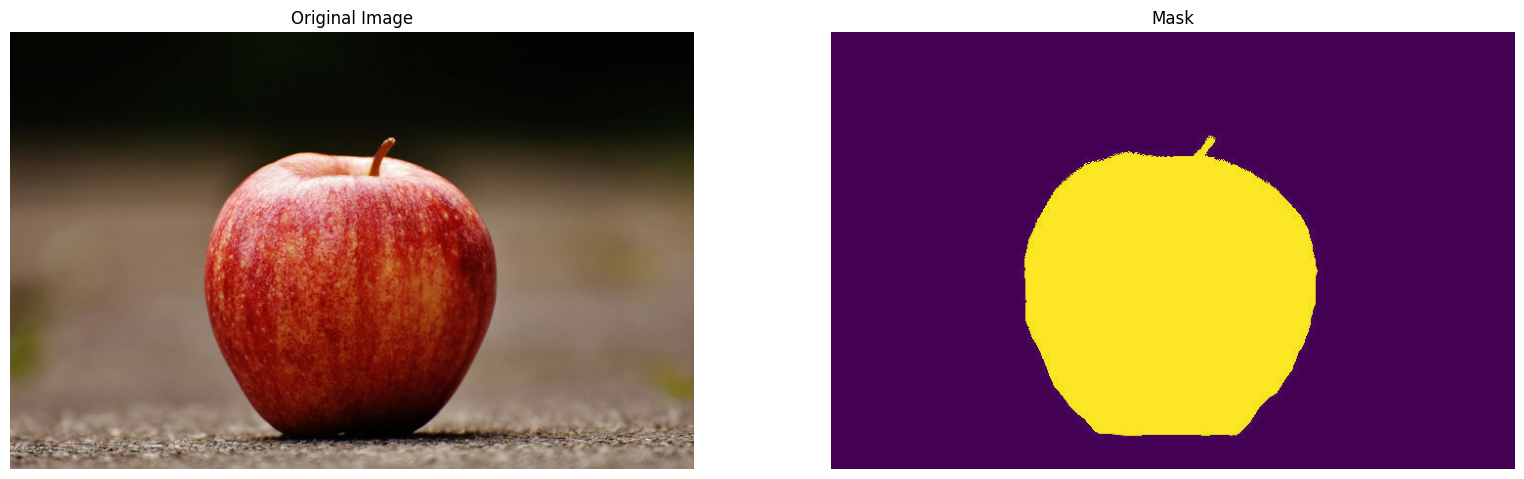

In [35]:
# Read the image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("Image size:", img.shape)

mask_image = cv2.imread(mask_path)
mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)[:,:]


utils.display_images([img, mask_image], titles=['Original Image', 'Mask'])

# Saliency Manipulation

In [68]:
# Initialize tau +/-
tau_positive = 0.2
tau_negative = 0.05
prev_tau_positive = tau_positive
prev_tau_negative = tau_negative

J_in = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
J_out = np.array([])

#### Partial Algorithm

You must do the iteration yourself :) 

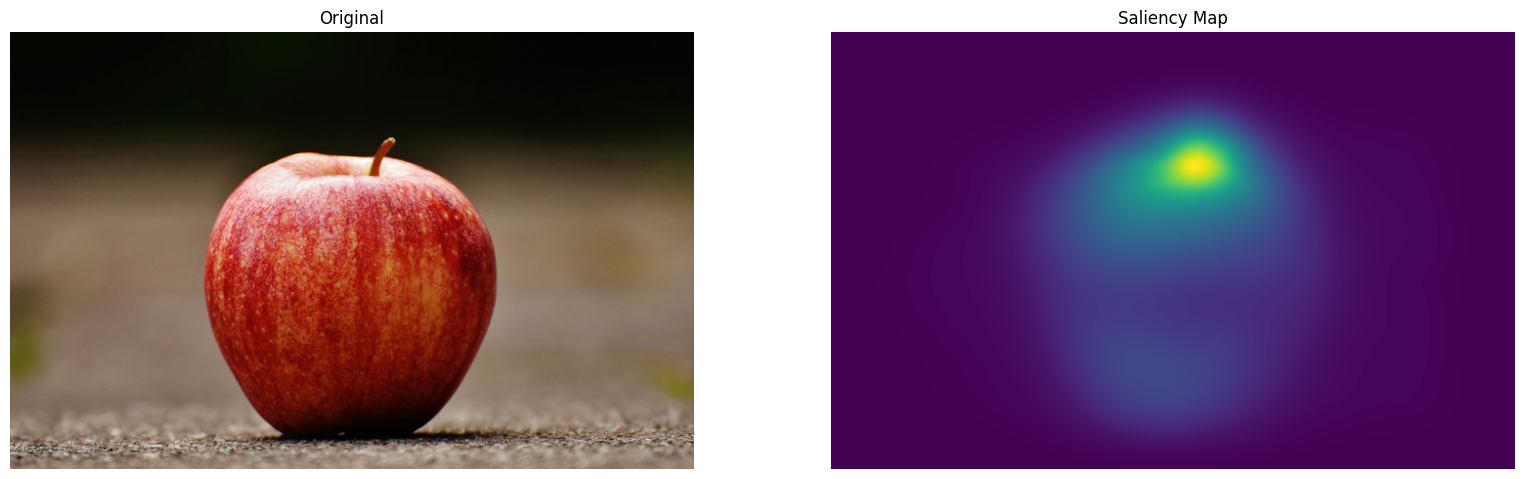

In [37]:
# Compute Saliency
s_map = compute_saliency_map(J_in)

utils.display_images([img, s_map], ['Original', 'Saliency Map'])

DB+ size: 33469, DB- size: 215630


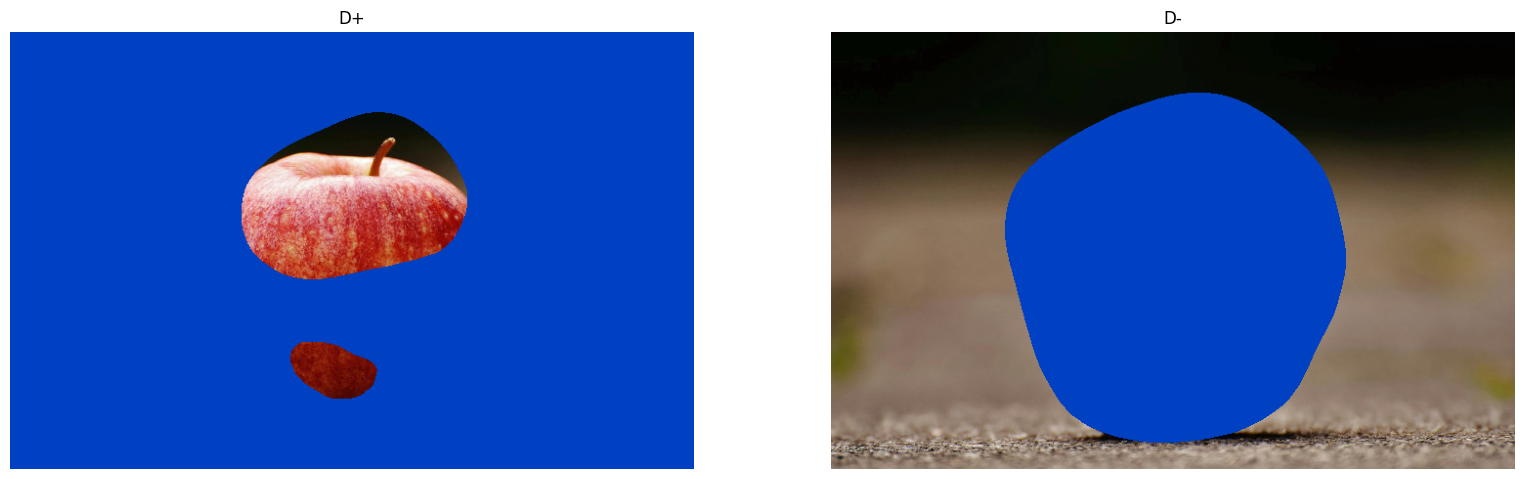

In [38]:
# DB update
D_positive, D_negative = compute_database(tau_positive, tau_negative, J_in, s_map)
print(f"DB+ size: {D_positive.shape[0]}, DB- size: {D_negative.shape[0]}")

# Construct and display the database's images
I_D_positive, I_D_negative = db.compute_image_database(J_in, D_positive, D_negative)

utils.display_images([I_D_positive, I_D_negative], ['D+', 'D-'])

Search-and-vote

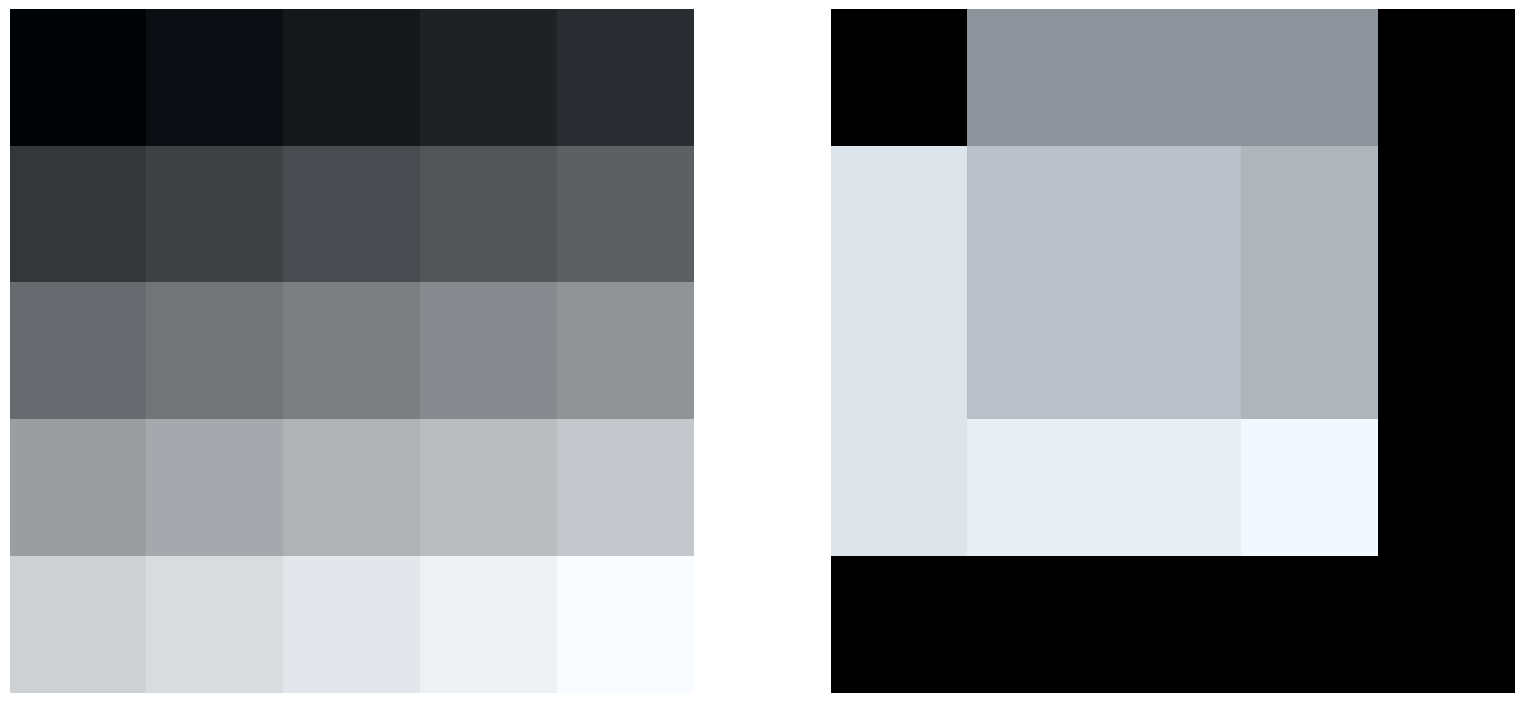

In [39]:
a = np.arange(75).reshape((5,5,3)) / 74
searched_patches_map = np.zeros((5,5,4))
patch_size=5
p_idxs = np.indices((3,3)).reshape(2, -1).T -1
for x in range(1,a.shape[0]-1, 2):
    for y in range(1, a.shape[1]-1, 2):
        x = np.random.randint(1,a.shape[0]-1)
        y = np.random.randint(1,a.shape[1]-1)
        p = a[x-1:x+2, y-1:y+2]
        s = searched_patches_map[x-1:x+2, y-1:y+2]

        # new_mean (per pixel) = temp_mean * N/(N+p*p) + p_mean / N+p*p
        n_plus_p2 = (s[:,:,3] + patch_size**2)
        s[:,:,:-1] *= (s[:,:,3] / n_plus_p2)[:,:,None]
        s[:,:,:-1] += np.ones_like(p) * p.sum(axis=(0,1)) / n_plus_p2[:,:,None]
        s[:,:,-1] = n_plus_p2.copy()
        

b = searched_patches_map[:,:,0:3]
b /= b.max()
utils.display_images([a,b])

In [40]:
# PATCHMATHC = SEARCH

patch_size = 7
stride = 3

width, height, _ = J_in.shape
radius = patch_size // 2

# Pad the image so that the patch don't overlap. (dont look, just know it works)
J_paded = np.stack([np.pad(J_in[:,:,i], radius, mode="reflect") for i in range(3)]).transpose(1,2,0)

# Create the mapping from a pixel location to (the current mean of the overlapping patches, number of elements. 
searched_patches_map = np.zeros((J_paded.shape[0], J_paded.shape[1], 4)) # 4 = (curr_r_mean, curr_g_mean, curr_b_mean, # seen pixels)

# Loop through all centers of each patch
for x in range(0, width, stride):
    for y in range(0, height, stride):
        # Because of pading, (x, y) actualy reprensent top left corner of patch 
        patch = J_paded[x:x+patch_size, y:y+patch_size]

        if mask_image[x, y] > 0 and len(D_positive) > 0:
            # Inside the mask (more salient)
            best_match = opt.find_best_match(patch, D_positive, J_paded)

        elif len(D_negative) > 0:
            # Outside the mask (less salient)
            best_match = opt.find_best_match(patch, D_negative, J_paded)
        else:
            best_match = patch  # If DB is empty keep orignal patch
        
        # VOTING STEP (but done on the fly)

        s = searched_patches_map[x:x+patch_size, y:y+patch_size]

        # TODO: filter out what is not in the "corect" given region
        # new_mean (per pixel) = temp_mean * N/(N+p*p) + p_mean / N+p*p
        n_plus_p2 = (s[:,:,3] + patch_size**2)
        s[:,:,:-1] *= (s[:,:,3] / n_plus_p2)[:,:,None]
        s[:,:,:-1] += np.ones_like(best_match) * best_match.sum(axis=(0,1)) / n_plus_p2[:,:,None]
        s[:,:,-1] = n_plus_p2.copy()

# Unpad the image
J_patched_padded = searched_patches_map[:, :, :-1]

# Put back in range [0, 255]
J_patched_padded = np.floor(J_patched_padded).astype(np.uint8)

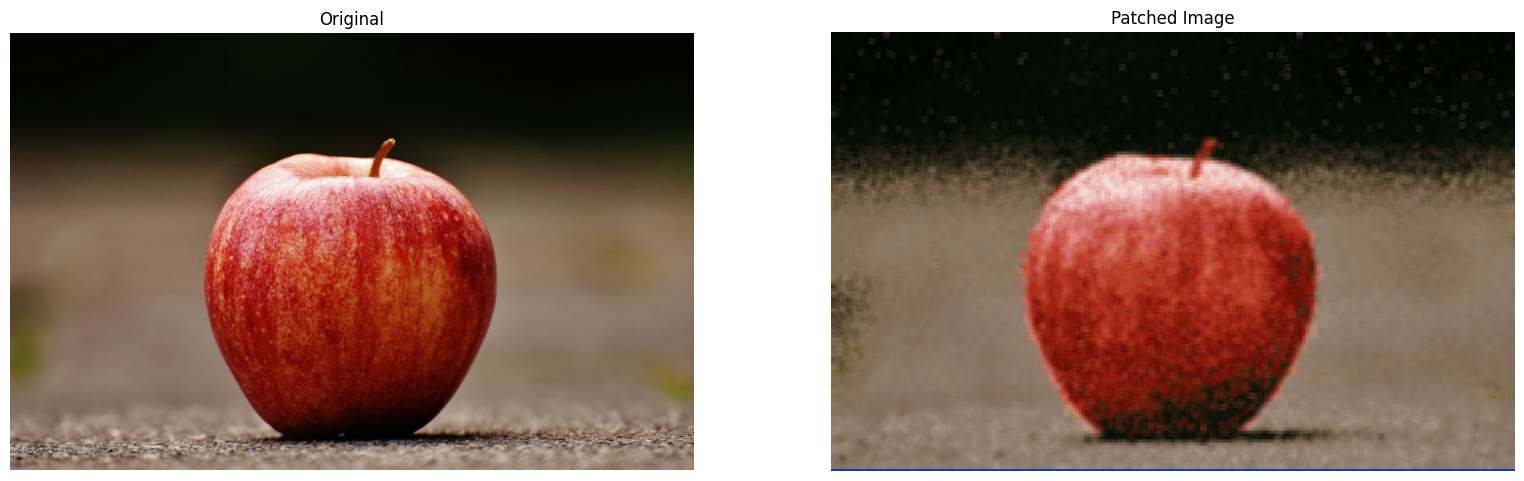

In [45]:
# Display patchMatch
J_patched_rgb = cv2.cvtColor(J_patched_padded, cv2.COLOR_Lab2RGB)
utils.display_images([img, J_patched_rgb], ['Original', 'Patched Image'])

Recursive patchy


In [115]:
from collections import deque
import numpy as np

def get_flat_layer_index(x, y, patch_size):
    # Unique layer per patch alignment offset
    return (x % patch_size) + patch_size * (y % patch_size)

def extract_patch(image, x, y, patch_size):
    r = patch_size // 2
    return image[x - r:x + r + 1, y - r:y + r + 1]

def vote_patch(searched_patches_map, patch, x, y):
    r = patch.shape[0] // 2
    s = searched_patches_map[x - r:x + r + 1, y - r:y + r + 1]
    
    # Pixelwise patch voting (no patch flattening)
    s[:, :, :3] = (s[:, :, :3] * s[:, :, 3, None] + patch) / (s[:, :, 3, None] + 1)
    s[:, :, 3] += 1

def in_bounds(x, y, shape, patch_size):
    r = patch_size // 2
    return r <= x < shape[0] - r and r <= y < shape[1] - r

def bfs_patchmatch(center_x, center_y, visited, J_in, patch_size, D_positive, D_negative,image_layers, mask, mode='auto', max_depth=100):
    queue = deque()
    queue.append((center_x, center_y, 0))

    while queue:
        x, y, depth = queue.popleft()

        if not in_bounds(x, y, visited.shape, patch_size) or visited[x, y] or depth > max_depth:
            continue

        visited[x, y] = True
        patch = extract_patch(J_in, x, y, patch_size)

        if mode == 'auto':
            if mask[x, y] > 0 and len(D_positive) > 0:
                best_match = find_best_match(patch, D_positive)
            elif len(D_negative) > 0:
                best_match = find_best_match(patch, D_negative)
            else:
                best_match = patch
        else:
            best_match = find_best_match(patch, D_positive if mode == 'pos' else D_negative)

        layer_id = get_flat_layer_index(x, y, patch_size)
        vote_patch(image_layers[layer_id], best_match, x, y)

        for dx, dy in [(-patch_size, 0), (patch_size, 0), (0, -patch_size), (0, patch_size)]:
            queue.append((x + dx, y + dy, depth + 1))

def merge_layers(image_layers):
    final = np.zeros_like(image_layers[0][:, :, :3], dtype=np.float32)
    weight = np.zeros(image_layers[0].shape[:2], dtype=np.float32)

    for layer in image_layers:
        final += layer[:, :, :3]
        weight += layer[:, :, 3]

    weight = np.maximum(weight, 1e-5)
    final = final / weight[:, :, None]

    return final  # Still in Lab (float32)

def patchmatch_recursive_driver(J_in, mask, patch_size, D_positive, D_negative, max_depth=100):
    H, W, _ = J_in.shape
    visited = np.zeros((H, W), dtype=bool)

    num_layers = patch_size ** 2
    image_layers = [np.zeros((H, W, 4), dtype=np.float32) for _ in range(num_layers)]

    center_x, center_y = H // 2, W // 2
    bfs_patchmatch(center_x, center_y, visited, J_in, patch_size,D_positive, D_negative, image_layers, mask, max_depth=max_depth)

    merged = merge_layers(image_layers)
    return merged


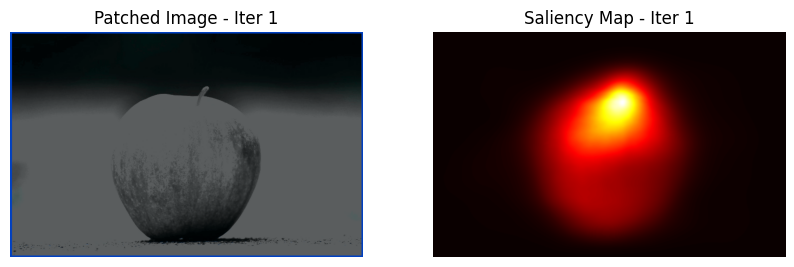

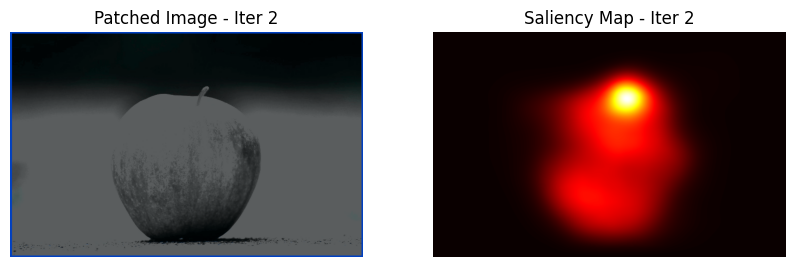

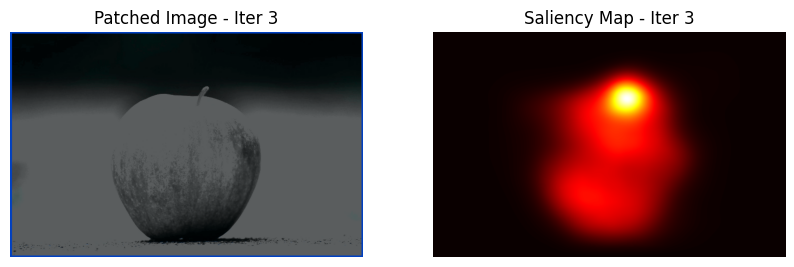

In [117]:
# --- Parameters ---
tau_positive = 0.3
tau_negative = 0.3
learning_rate = 0.1
PATCH_SIZE = 7
max_depth = 999
delta_s = 0.6
run_times = 3

# Start from original RGB image
J_in = cv2.cvtColor(img, cv2.COLOR_RGB2Lab).astype(np.float32)

for i in range(run_times):
    # --- Compute Saliency Map ---
    rgb_for_saliency = cv2.cvtColor(np.clip(J_in, 0, 255).astype(np.uint8), cv2.COLOR_Lab2RGB)
    s_map = compute_saliency_map(rgb_for_saliency)

    # --- Compute Patch Databases ---
    D_positive, D_negative = compute_database(tau_positive, tau_negative, J_in, s_map)

    # --- Recursive PatchMatch ---
    J_in = patchmatch_recursive_driver(J_in, mask_image, PATCH_SIZE, D_positive, D_negative, max_depth=max_depth)

    # --- Clamp to valid Lab ranges ---
    J_in[:, :, 0] = np.clip(J_in[:, :, 0], 0, 100)
    J_in[:, :, 1:] = np.clip(J_in[:, :, 1:], -128, 127)
    J_uint8 = J_in.astype(np.uint8)
    J_rgb = cv2.cvtColor(J_uint8, cv2.COLOR_Lab2RGB)

    # --- Display image and saliency map ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(J_rgb)
    plt.title(f"Patched Image - Iter {i+1}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(s_map, cmap="hot")
    plt.title(f"Saliency Map - Iter {i+1}")
    plt.axis("off")
    plt.show()

    # --- Update thresholds based on saliency error ---
    saliency_foreground = np.mean(s_map[mask_image > 0])
    saliency_background = np.mean(s_map[mask_image == 0])
    current_contrast = saliency_foreground - saliency_background
    adjustment = np.abs(current_contrast - delta_s) * learning_rate
    tau_positive += adjustment
    tau_negative -= adjustment


In [112]:
print("Input image dtype:", img.dtype)
print("Input image min/max:", img.min(), img.max())

Input image dtype: uint8
Input image min/max: 0 255


J_in dtype: float32 | min: 0.0 max: 127.0


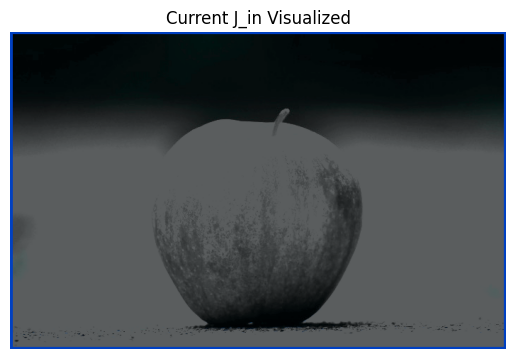

In [107]:
print("J_in dtype:", J_in.dtype, "| min:", J_in.min(), "max:", J_in.max())

# Force Lab -> RGB conversion safely
if J_in.dtype != np.uint8:
    J_lab_display = np.clip(J_in, 0, 255).astype(np.uint8)
else:
    J_lab_display = J_in

J_rgb = cv2.cvtColor(J_lab_display, cv2.COLOR_Lab2RGB)

plt.imshow(J_rgb)
plt.title("Current J_in Visualized")
plt.axis("off")
plt.show()

In [ ]:
# Compute saliency maps
sal_before = compute_saliency_map(img)
sal_after = compute_saliency_map(J_rgb)

# Compute mean saliency inside and outside mask
s_before_fg = np.mean(sal_before[mask_image > 0])
s_before_bg = np.mean(sal_before[mask_image == 0])
s_after_fg = np.mean(sal_after[mask_image > 0])
s_after_bg = np.mean(sal_after[mask_image == 0])

print("Before: ΔS =", round(s_before_fg - s_before_bg, 4))
print("After:  ΔS =", round(s_after_fg - s_after_bg, 4))

Before: ΔS = 0.267
After:  ΔS = 0.2591


Poisson Screening

In [ ]:
poisson_padded = opt.screen_poisson(J_paded, J_patched_padded, lambda_factor=5.)

# un-pad the image
J_out = np.floor(poisson_padded[radius:width+radius, radius:height+radius]).astype(np.uint8)

error: OpenCV(4.11.0) D:/a/opencv-python/opencv-python/opencv/modules/imgproc/src/filter.simd.hpp:3252: error: (-213:The function/feature is not implemented) Unsupported combination of source format (=1), and destination format (=6) in function 'cv::opt_AVX2::getLinearFilter'


In [13]:
# Display Resutls
J_out_rgb = cv2.cvtColor(J_out, cv2.COLOR_Lab2RGB)
diff = np.abs(img - J_out_rgb).mean(axis=2) / 255
print(diff.min(), diff.max())
utils.display_images([img, J_out_rgb, diff], ['Original', 'Modified Saliency', 'diff'])


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


##### Poisson lambda factor test

In [15]:
poissons = []
lambdas = np.logspace(-5,0, 6) * 5

for l in lambdas:
    poisson_padded = opt.screen_poisson(J_paded, J_patched_padded, lambda_factor=l)

    # un-pad the image
    poissons.append(np.floor(poisson_padded[radius:-radius, radius:-radius]).astype(np.uint8))


error: OpenCV(4.11.0) D:/a/opencv-python/opencv-python/opencv/modules/imgproc/src/filter.simd.hpp:3252: error: (-213:The function/feature is not implemented) Unsupported combination of source format (=1), and destination format (=6) in function 'cv::opt_AVX2::getLinearFilter'


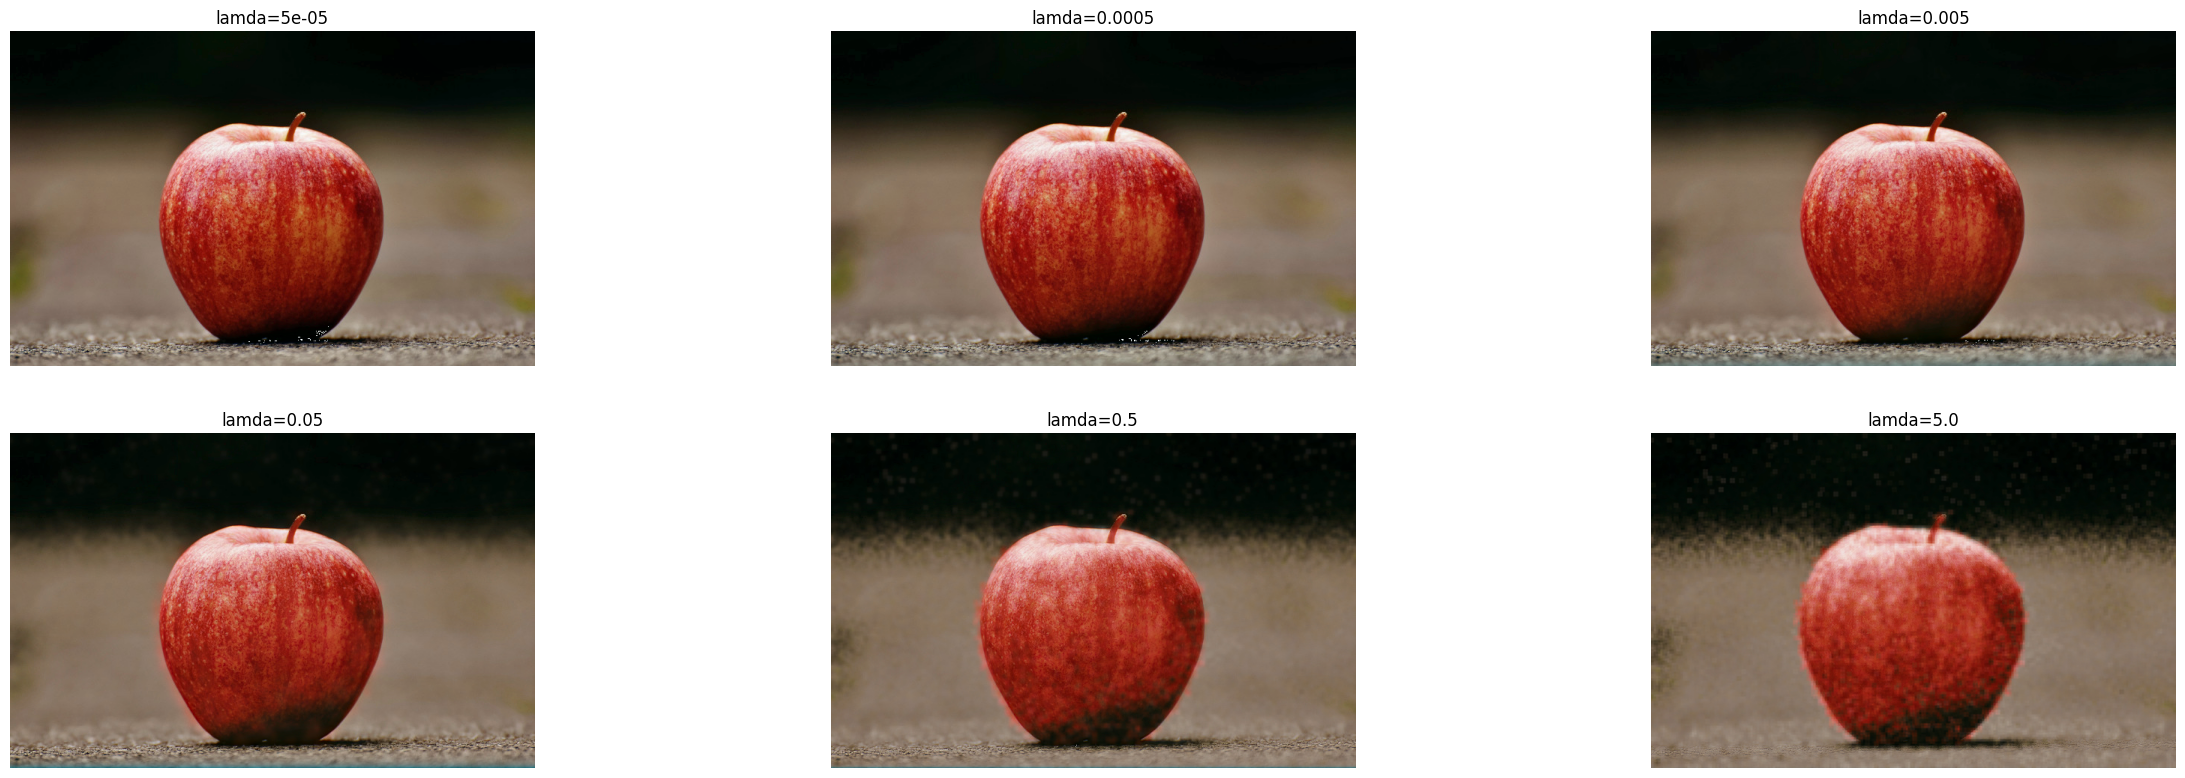

In [106]:
# Display results
utils.display_images([cv2.cvtColor(p, cv2.COLOR_Lab2RGB) for p in poissons], [f'lamda={l}' for l in lambdas])

(un-comment if you want to manualy iterate)

In [ ]:
# # switch the buffers
# temp = J_in.copy()
# J_in = J_out
# J_out = J_in

# # Update tau +/-
# tau_positive, tau_negative = update_taus(tau_positive, tau_negative, s_map, mask_image, delta_s)
# print(f'\n4Tau+: {tau_positive}, Tau-: {tau_negative}')


#### Full Algorithm

In [117]:
nb_iterations = 1

print("Begin Saliency Manipulation:")

# while compute_criterion(S_J, R, delta_s) > EPSILON:
for x in  range(nb_iterations):
    print(f"Iteration {x}")
    # update the saliency map
    print(" - computing Saliency...")
    s_map = compute_saliency_map(J_in)
    print(" - Done.")

    # DB update
    print(" - computing DB...")
    D_positive, D_negative = compute_database(tau_positive, tau_negative, J_in, s_map)
    print(f" - Done, DB+ size: {D_positive.shape[0]}, DB- size: {D_negative.shape[0]}")
    
    # Construct and display the database's images
    I_D_positive, I_D_negative = db.compute_image_database(J_in, D_positive, D_negative)

    # utils.display_images([S_J, I_D_positive, I_D_negative])

    # update J to minimize the energy function
    print(" - Minimizing function...")
    J_out = minimize_J(J_in, mask_image, D_positive, D_negative)
    print(" - Done.")
    # Update tau +/-
    tau_positive, tau_negative = update_taus(tau_positive, tau_negative, s_map, mask_image, delta_s)

    # switch the buffers (only affect the references so no copy is made)
    temp = J_in.copy()
    J_in = J_out
    J_out = J_in

    # Check if convergence is reached by tau's
    tau_diff = abs(tau_positive - prev_tau_positive) + abs(tau_negative - prev_tau_negative)
    prev_tau_positive, prev_tau_negative = tau_positive, tau_negative
    if tau_diff < EPSILON:
        break

    # print("\033[A\033[K\033[A\033[K\033[A\033[K\033[A\033[K\033[A\033[K\033[A\033[K\033[A\033[K", end="")
    
# Cancel the last input-output exchange
temp = J_in.copy()
J_in = J_out
J_out = J_in

print("Done")
J_out = cv2.cvtColor(J_out, cv2.COLOR_Lab2RGB)

Begin Saliency Manipulation:
Iteration 0
 - computing Saliency...
 - Done.
 - computing DB...
 - Done, DB+ size: 33469, DB- size: 215630
 - Minimizing function...
  - Applying PatchMatch...
  - Applying Poisson Screening... - Done.
Done


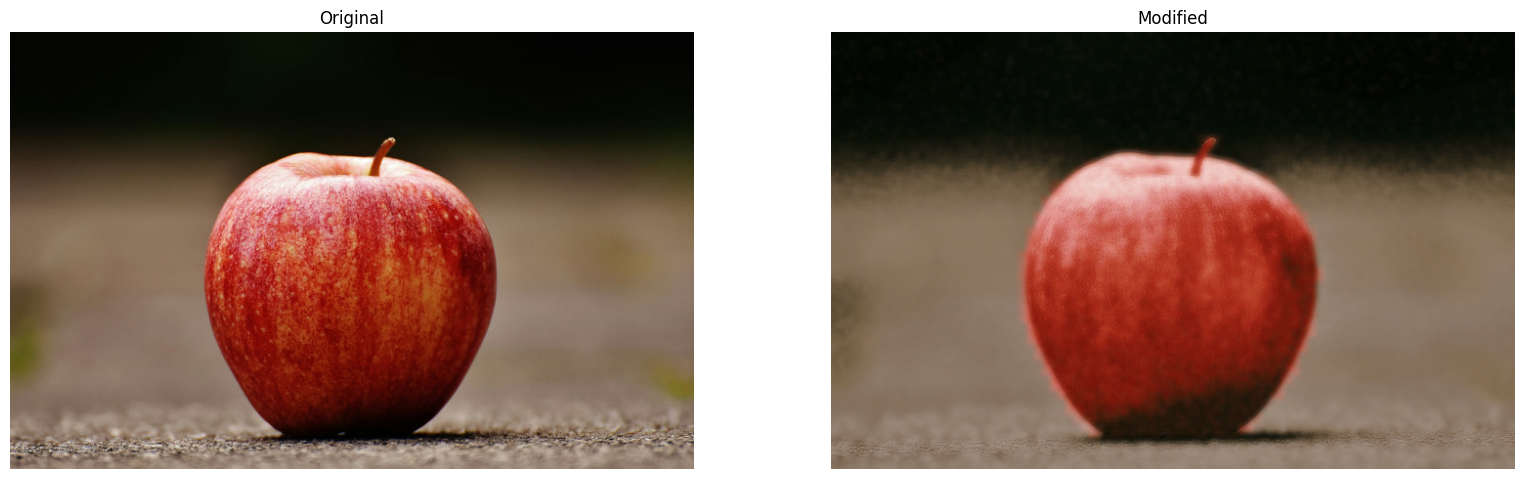

In [118]:
# Display results
utils.display_images([img, J_out], ['Original', 'Modified'])